In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import seaborn as sb
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [54]:
file_path= r"C:\Users\subha\Desktop\AgriSage\Data\Crop_Recommendation.csv"
raw_data= pd.read_csv (file_path)

In [57]:
features= raw_data.columns[:-1]
features

Index(['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity',
       'pH_Value', 'Rainfall'],
      dtype='object')

In [58]:
print(raw_data.columns)

Index(['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity',
       'pH_Value', 'Rainfall', 'Crop'],
      dtype='object')


In [59]:
target = 'Crop'

In [60]:
print(raw_data.head())

   Nitrogen  Phosphorus  Potassium  Temperature   Humidity  pH_Value  \
0        90          42         43    20.879744  82.002744  6.502985   
1        85          58         41    21.770462  80.319644  7.038096   
2        60          55         44    23.004459  82.320763  7.840207   
3        74          35         40    26.491096  80.158363  6.980401   
4        78          42         42    20.130175  81.604873  7.628473   

     Rainfall  Crop  
0  202.935536  Rice  
1  226.655537  Rice  
2  263.964248  Rice  
3  242.864034  Rice  
4  262.717340  Rice  


In [61]:
print(raw_data['Crop'])


0         Rice
1         Rice
2         Rice
3         Rice
4         Rice
         ...  
2195    Coffee
2196    Coffee
2197    Coffee
2198    Coffee
2199    Coffee
Name: Crop, Length: 2200, dtype: object


In [64]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

def transform_data(df, target, num_features):
    # Ensure num_features is a list
    if isinstance(num_features, pd.Index):
        num_features = num_features.tolist()
    # Encoding target
    onehot_encoder = OneHotEncoder(sparse_output=False)
    target_encoded = onehot_encoder.fit_transform(df[[target]])

    # Creating a DataFrame with encoded target columns
    target_encoded_df = pd.DataFrame(target_encoded, columns=[f"{target}_{cat}" for cat in onehot_encoder.categories_[0]])

    # Concatenate the original DataFrame with the new one-hot encoded target columns
    df = pd.concat([df.drop(target, axis=1), target_encoded_df], axis=1)

    # Assigning features and labels
    x = df.drop(target_encoded_df.columns, axis=1)
    y = df[target]  # Use original target column for labels

    # Splitting the dataset into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=101)

    # Standardization and Encoding
    # Define transformers for different column types
    std_scaler = StandardScaler()
    quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)

    # Combine transformers for specific columns
    preprocessor = ColumnTransformer([
        ("num_std", std_scaler, num_features),
        #("num_quantile", quantile_transformer, num_features) # Uncomment this line if you really want Quantile transformation instead of or in addition to standard scaling
    ])

    # Fit transformers on training data only
    preprocessor.fit(x_train)

    # Transform train and test data using fitted transformers
    x_train_transformed = preprocessor.transform(x_train)
    x_test_transformed = preprocessor.transform(x_test)

    return x_train_transformed, x_test_transformed, y_train.values.ravel(), y_test.values.ravel()




In [65]:
x_train, x_test, y_train, y_test= transform_data(raw_data, target, features)

KeyError: 'Crop'

In [66]:
y_train.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [31]:
# Convert NumPy array to Pandas Series
y_train_series = pd.Series(y_train)

# Now you can use DataFrame/Series methods
print(y_train_series.head())  # Print the first few elements


0     MothBeans
1        Coffee
2      MungBean
3     MothBeans
4    Watermelon
dtype: object


In [29]:
y_train.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [33]:
y_train

array(['MothBeans', 'Coffee', 'MungBean', ..., 'Coffee', 'Rice', 'Mango'],
      dtype=object)

In [32]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.multioutput import MultiOutputClassifier
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd

def model_comparison(x, y, models):
    names = []
    scoring = ['accuracy']
    
    # Create a dataframe to store the different metric values for each algorithm
    df_results = pd.DataFrame(columns=['Algorithm', 'Acc Mean', 'Acc STD'])
    results_acc = []  # List of accuracy scores for each fold of each algorithm
    
    for name, model in models:
        names.append(name)
        multi_output_model = MultiOutputClassifier(model)
        kfold = KFold(n_splits=10, shuffle=True, random_state=101)
        result = cross_validate(multi_output_model, x, y, cv=kfold, scoring=scoring, return_train_score=False)
        
        # Mean and standard deviation of Accuracy scores for the algorithm
        acc_mean = result['test_accuracy'].mean()
        acc_std = result['test_accuracy'].std()
        
        # Create the row of the results
        df_result_row = {'Algorithm': name, 'Acc Mean': acc_mean, 'Acc STD': acc_std}
        # Add the row to the results data frame
        df_results = pd.concat([df_results, pd.DataFrame([df_result_row])], ignore_index=True)
        
        results_acc.append(result['test_accuracy'])

    df_results = df_results.set_index('Algorithm')
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    # Display the mean and standard deviation of all metrics for all algorithms
    print(df_results) 
    # Convert the results_acc dictionary into a DataFrame for plotting
    results_acc_df = pd.DataFrame(results_acc).T
    # Create a box plot for the accuracy results
    plt.figure(figsize=(12, 8))
    ax = sb.boxplot(data=results_acc_df)
    ax.set_title('Model Comparison - Accuracy Scores')
    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Accuracy')
    ax.set_xticklabels(names) 
    plt.show()


In [21]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier


ens_models = []
ens_models.append(('RFC', RandomForestClassifier()))
ens_models.append(('ABC', AdaBoostClassifier()))
ens_models.append(('GBC', GradientBoostingClassifier()))


In [27]:
y_train

,Crop_Apple,Crop_Banana,Crop_Blackgram,Crop_ChickPea,Crop_Coconut,Crop_Coffee,Crop_Cotton,Crop_Grapes,Crop_Jute,Crop_KidneyBeans,...,Crop_Mango,Crop_MothBeans,Crop_MungBean,Crop_Muskmelon,Crop_Orange,Crop_Papaya,Crop_PigeonPeas,Crop_Pomegranate,Crop_Rice,Crop_Watermelon
2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1528,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1084,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


C:\Users\subha\AppData\Local\Temp\ipykernel_21596\3457372423.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([df_result_row])], ignore_index=True)
c:\Users\subha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\subha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.w

           Acc Mean  Acc STD
Algorithm                   
RFC           0.970    0.013
ABC           0.964    0.015
GBC           0.969    0.016


C:\Users\subha\AppData\Local\Temp\ipykernel_21596\3457372423.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names)


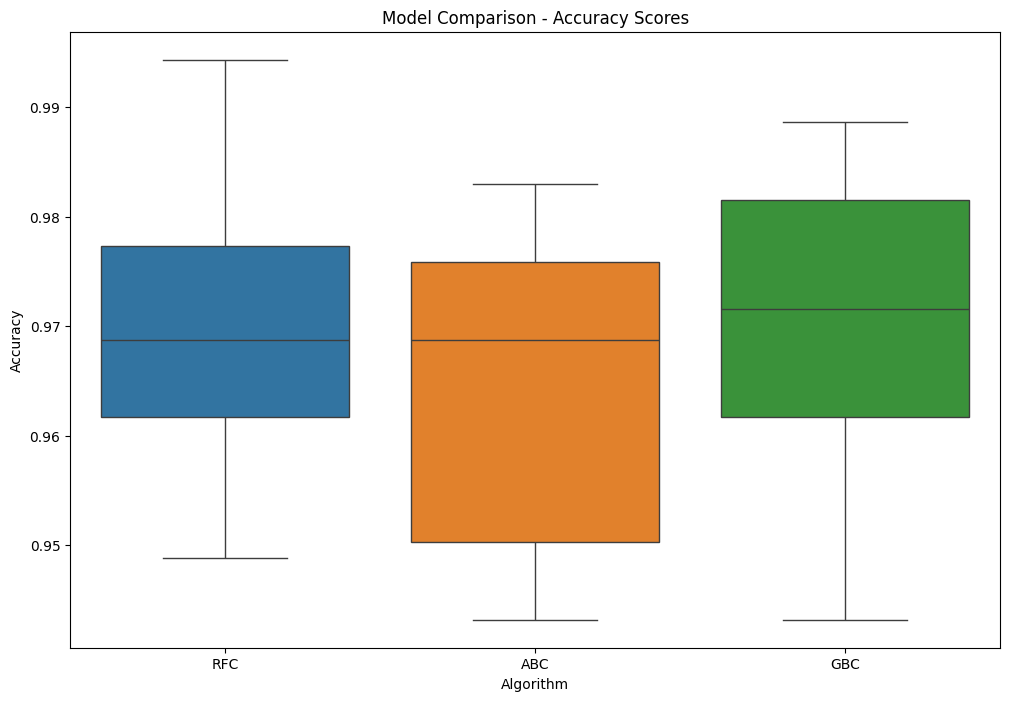

In [31]:
model_comparison(x_train, y_train, ens_models)
